<img align="left" src="https://lever-client-logos.s3.amazonaws.com/864372b1-534c-480e-acd5-9711f850815c-1524247202159.png" width=200>
<br></br>

# Vector Representations
## *Data Science Unit 4 Sprint 2 Assignment 2*

In [1]:
import re
import string

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import spacy

from bs4 import BeautifulSoup

## 1) *Clean:* Job Listings from indeed.com that contain the title "Data Scientist" 

You have `job_listings.csv` in the data folder for this module. The text data in the description column is still messy - full of html tags. Use the [BeautifulSoup](https://www.crummy.com/software/BeautifulSoup/bs4/doc/) library to clean up this column. You will need to read through the documentation to accomplish this task. 

In [2]:
from bs4 import BeautifulSoup
import pandas as pd
import requests
import re

df = pd.read_csv('./data/job_listings.csv')
df['description'] = df['description'].apply(lambda text: BeautifulSoup(text, 'html.parser').get_text())

df.head()

,Unnamed: 0,description,title
0,0,"b""Job Requirements:\nConceptual understanding ...",Data scientist
1,1,"b'Job Description\n\nAs a Data Scientist 1, yo...",Data Scientist I
2,2,b'As a Data Scientist you will be working on c...,Data Scientist - Entry Level
3,3,"b'$4,969 - $6,756 a monthContractUnder the gen...",Data Scientist
4,4,b'Location: USA \xe2\x80\x93 multiple location...,Data Scientist


In [3]:
ds_df = df[df['title'].str.contains('Data Scientist', flags=re.IGNORECASE)]
ds_df.head()

,Unnamed: 0,description,title
0,0,"b""Job Requirements:\nConceptual understanding ...",Data scientist
1,1,"b'Job Description\n\nAs a Data Scientist 1, yo...",Data Scientist I
2,2,b'As a Data Scientist you will be working on c...,Data Scientist - Entry Level
3,3,"b'$4,969 - $6,756 a monthContractUnder the gen...",Data Scientist
4,4,b'Location: USA \xe2\x80\x93 multiple location...,Data Scientist


In [4]:
ds_df.head()

,Unnamed: 0,description,title
0,0,"b""Job Requirements:\nConceptual understanding ...",Data scientist
1,1,"b'Job Description\n\nAs a Data Scientist 1, yo...",Data Scientist I
2,2,b'As a Data Scientist you will be working on c...,Data Scientist - Entry Level
3,3,"b'$4,969 - $6,756 a monthContractUnder the gen...",Data Scientist
4,4,b'Location: USA \xe2\x80\x93 multiple location...,Data Scientist


## 2) Use Spacy to tokenize the listings 

In [5]:
# Imports

import spacy
from spacy.tokenizer import Tokenizer
nlp = spacy.load("en_core_web_lg")
tokenizer = Tokenizer(nlp.vocab)

In [6]:
# I'm going to go ahead and extend the stop words
STOP_WORDS = nlp.Defaults.stop_words.union(["job", "data", "description", 
                                            "requirements", "scientist", "you", "will",
                                            "apply", "now", "opportunity", "position",
                                            "team", "work", "experience", "science", "company",
                                            "job"]) # These are all irrelevant

ds_df = ds_df.reset_index(drop=True)  # Issue with index resolved

for i in range(len(ds_df)):
    ds_df['description'][i] = ds_df['description'][i].replace('\\n', ' ')  # Gets rid of line breaks
    ds_df['description'] = ds_df['description'].apply(lambda x: re.sub(r'[^a-zA-Z ]', '', x))  # Remove punctuation w/ Regex
    ds_df['description'][i] = ds_df['description'][i][1:]  # Gets rid of 'b' at the front

ds_df['description'].sample(5)

/home/kenneth/anaconda3/envs/U4S1/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/home/kenneth/anaconda3/envs/U4S1/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


332     a yearLRS Consulting Services has been delive...
100    Customer Facing Data Scientists CFDSs are crit...
144    Data ScientistnnRedjack is growing We protect ...
288    Fullpower is the technology leader for cloudba...
380    Position DescriptionnAs the Walmart Voice Comm...
Name: description, dtype: object

In [7]:
tokens = []  # Empty list to populate with our tokens.

for doc in tokenizer.pipe(ds_df['description'], batch_size=300):
    
    doc_tokens = []  # Empty list to populate
    
    for token in doc:
        if (token.text.lower() not in STOP_WORDS) & (token.is_punct == False):
            doc_tokens.append(token.text.lower())
    tokens.append(doc_tokens)
    
ds_df['tokens'] = tokens

ds_df.head()

,Unnamed: 0,description,title,tokens
0,0,Job Requirements Conceptual understanding in M...,Data scientist,"[conceptual, understanding, machine, learning,..."
1,1,Job DescriptionnnAs a Data Scientist you will...,Data Scientist I,"[descriptionnnas, , help, build, machine, lea..."
2,2,As a Data Scientist you will be working on con...,Data Scientist - Entry Level,"[working, consulting, business, responsible, a..."
3,3,a monthContractUnder the general supervisio...,Data Scientist,"[ , monthcontractunder, general, supervision..."
4,4,Location USA xexx multiple locationsn years of...,Data Scientist,"[location, usa, xexx, multiple, locationsn, ye..."


## 3) Use Scikit-Learn's CountVectorizer to get word counts for each listing.

In [8]:
# Imports

from sklearn.feature_extraction.text import CountVectorizer

# First, create the transformer.
vect = CountVectorizer(stop_words='english', min_df=0.025, max_df=0.90, lowercase=True)

# Build Vocab
vect.fit(ds_df['description'])

# Transform the text
dtm = vect.transform(ds_df['description'])

dtm = pd.DataFrame(dtm.todense(), columns=vect.get_feature_names())

print('Number of Times Each Word Appeared in Data Scientist listings:')
dtm.head()

Number of Times Each Word Appeared in Data Scientist listings:


,ab,abilities,ability,able,academic,accelerate,accept,access,accessible,accommodation,...,xexx,xexxcbig,year,years,yearsxexx,york,youll,youre,youxexxll,youxexxre
0,0,0,2,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,1,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,1,0,0,1,0,0,0,0,0,0


## 4) Visualize the most common word counts

In [9]:
# This will create a dataframe sorted by the most to least popular words.
most_common_words = pd.DataFrame(dtm.sum().sort_values(ascending=False))

most_common_words.reset_index(inplace=True)  # Resetting the index to replace column names

most_common_words.columns = ['word', 'count']

most_common_words.head()

,word,count
0,business,998
1,experience,964
2,work,850
3,science,815
4,learning,794


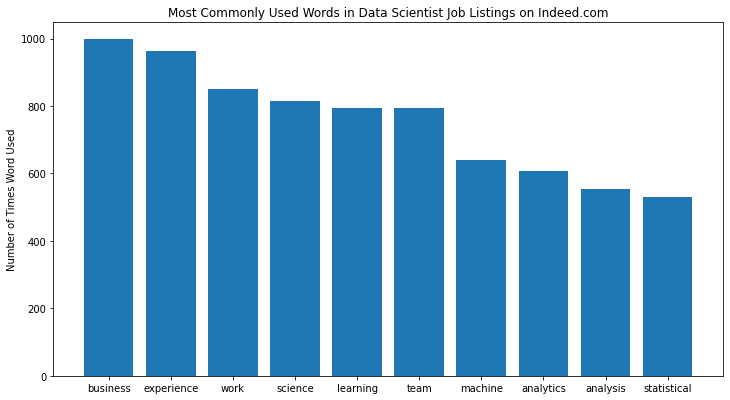

In [10]:
from pylab import rcParams
rcParams['figure.figsize'] = 12, 6.5

ten_most_common_words = most_common_words.head(10)  # The 10 most common words

plt.bar(x=ten_most_common_words['word'], height=ten_most_common_words['count'])
plt.ylabel('Number of Times Word Used')
plt.title('Most Commonly Used Words in Data Scientist Job Listings on Indeed.com')
plt.show();

## 5) Use Scikit-Learn's tfidfVectorizer to get a TF-IDF feature matrix

In [11]:
# Function from lesson
def tokenize(document):
    
    doc = nlp(document)
    
    return [token.lemma_.strip() for token in doc if (token.text.lower() not in STOP_WORDS) and (token.is_punct != True)]

In [12]:
# Imports
from sklearn.feature_extraction.text import TfidfVectorizer

# Instantiate Vectorizer
tfidf = TfidfVectorizer(stop_words='english', ngram_range=(1,3),
                        max_df=0.9, min_df=2, max_features=3750,
                        tokenizer=tokenize)

# Create vocabulary / get word counts
dtm = tfidf.fit_transform(ds_df['description'])

dtm = pd.DataFrame(dtm.todense(), columns=tfidf.get_feature_names())

dtm.head()

,,,ability,analytic,billion,city,city worldnnwe,company,country,deep,...,year relevant,year work,years,yearsxexx,york,york city,youxexxll,youxexxre,youxexxve,zf
0,0.043937,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.081669,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.070109,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## 6) Create a NearestNeighbor Model. Write the description of your ideal datascience job and query your job listings. 

In [13]:
# Import
from sklearn.neighbors import NearestNeighbors

# Fit nearest neighbors on dtm
nn = NearestNeighbors(n_neighbors=5, algorithm='kd_tree')
nn.fit(dtm)

NearestNeighbors(algorithm='kd_tree', leaf_size=30, metric='minkowski',
                 metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                 radius=1.0)

In [14]:
# Create query for description of ideal data science job

job_desc = ["""use effective data analytics skills and practices to develop, maintain, and improve 
reporting for marketing, and predictive modeling for forecasting future results and potential additions 
to our eCommerce solutions. You will collaborate with sales leadership and advise on opportunities to improve 
upon conversion rates, as well as evaluate execution and performance of marketing events 
based upon lead generation, PPC, and margin attributing to the overall efforts of marketing ROI, and offer potential
solutions to improve marketing efforts and convey predictions for these results using visualization techniques
including matplotlib and plotly. The individual in this position may also work on recommendation engines
to help decrease website bounce rate and increase revenue."""]

query = tfidf.transform(job_desc)

query

<1x3750 sparse matrix of type '<class 'numpy.float64'>'
	with 54 stored elements in Compressed Sparse Row format>

In [15]:
nn.kneighbors(query.todense())

(array([[1.24229406, 1.24333052, 1.25631599, 1.25643984, 1.28245913]]),
 array([[266, 396, 327, 217,  48]]))

In [16]:
ds_df['description'][266]

'We are Drybar a blow dry bar and we set out to shake up the beauty industry in our own specialty way We believe in doing one thing and being the best at it For us thatxexxs blowouts In fact our tagline says it best No cuts No color Just blowouts What started with one shop in Brentwood CA has grown to over  locations across  markets with more to comennDrybar is seeking a data scientist to join our Marketing team If you have a passion for xexxcwowingxexxd business leaders with progressive analytics techniques leading projects focused on optimizing marketing effectiveness and driving marketing innovation and working with managers who xexxcgetxexxd the work you are doing and support the value of analytics to drive brand results then Drybar is the place for younnWhat were all aboutnResponsibilitiesnData MungingnCollect data from a wide variety of corporate databases and Excel filesnUtilize your toolset in regular expressions to extract information from unstructured text documents and the w

## Stretch Goals

 - Try different visualizations for words and frequencies - what story do you want to tell with the data?
 - Scrape Job Listings for the job title "Data Analyst". How do these differ from Data Scientist Job Listings
 - Try and identify requirements for experience specific technologies that are asked for in the job listings. How are those distributed among the job listings?
 - Use a clustering algorithm to cluster documents by their most important terms. Do the clusters reveal any common themes?
  - **Hint:** K-means might not be the best algorithm for this. Do a little bit of research to see what might be good for this. Also, remember that algorithms that depend on Euclidean distance break down with high dimensional data.
 - Create a labeled dataset - which jobs will you apply for? Train a model to select the jobs you are most likely to apply for. :) 